## **1. Research Questions introduction**



	“Quais são os fatores (género, número de ratings, e popularidade) que mais influenciam a média de avaliação dos filmes no MovieLens?”

Isto permite:
	•	Explorar a estrutura e a distribuição dos dados (EDA);
	•	Criar métricas derivadas (popularidade, número de votos, média ponderada);
	•	Usar modelos simples (regressão linear / árvore de decisão) para quantificar o impacto de cada variável;
	•	E escalar a análise — localmente em DuckDB, e facilmente replicável em cloud (Athena/BigQuery).

Notas da reunião com o prof, 06.11
- Partilhar dificuldades com os colegas, documentar as escolhas no notebook 
- fazer um threshold para numero de ratings por exemplo que queremos considerar. abaixo de 100 pode ser pouco!
- sugeriu fazer uma análise temporal face a eventos da década por exemplo - 11 set torres gémeas , aparecimento da internet em 95
- existem users muito ativos, que contribuem com muitos comentários
- analisar de o género de filmes ou filmes mais populares vão variando ao longo do tempo. podemos ver se ha filmes mt antigos com ratings / tags recentes  - exemplo do sozinho em casa no natal??

Creio que podemos orientar cada um dos exploratory data analysis ao que queremos... depois mudar os titulos! nao sabia muito bem como por

## **2. Pipeline**

### **2.1. Import necessary libraries and packages**

In [59]:
import polars as pl
import pandas as pd
import duckdb
import sys
import os
import gdown # use pip install gdown for this - to download files from google drive 


pip install needed:

pip install polars pyarrow duckdb gdown

In [60]:
print(sys.executable)

#"C:\Users\SaraEstevesHenriques\AppData\Local\Programs\Python\Python313\python.exe" -m pip install pyarrow
# use version 313 of python

/opt/anaconda3/bin/python


### **2.2. Import dataset files - 32 stored on Google Drive**

The files that compose the dataset for a complete analysis were stored on a Google Drive folder accessible by the direct URL.
Source of files: https://grouplens.org/datasets/movielens/
Permalink: https://grouplens.org/datasets/movielens/32m/
Version: MovieLens 32M

Description from the source
MovieLens 32M movie ratings. Stable benchmark dataset. 32 million ratings and two million tag applications applied to 87,585 movies by 200,948 users. Collected 10/2023 Released 05/2024


In [61]:
# Google Drive folder URL
folder_url = "https://drive.google.com/drive/folders/1azViEYTwDAw6rsQoWKGWyw8iDxQiHWrs?usp=drive_link"
output_dir = "data"

os.makedirs(output_dir, exist_ok=True)

# Download files in the folder, where the dataset with 32m registries is stored in parquet format
gdown.download_folder(url=folder_url, output=output_dir, quiet=False, use_cookies=False)


Retrieving folder contents


Processing file 1Kb6G1Wjiz1TycoN8yS7l8a1HJCdGdqpe links_32m.parquet
Processing file 15iPCCprMP4AIUczoIQedLAGGEDgxnIMy movies_32m.parquet
Processing file 1-BUqGS_AxvUZcYZymNzMAk9l8JVsy1fs ratings_32m.parquet
Processing file 1H15eh-AlA-YS-5-IZbby-YWf5-5_LQ9F tags_32m.parquet


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Kb6G1Wjiz1TycoN8yS7l8a1HJCdGdqpe
To: /Users/soraiabornett/Documents/GitHub/BDF25_7/BDF25_7_data/big_data/ml-32m/data/links_32m.parquet
100%|██████████| 1.34M/1.34M [00:00<00:00, 8.83MB/s]
Downloading...
From: https://drive.google.com/uc?id=15iPCCprMP4AIUczoIQedLAGGEDgxnIMy
To: /Users/soraiabornett/Documents/GitHub/BDF25_7/BDF25_7_data/big_data/ml-32m/data/movies_32m.parquet
100%|██████████| 2.22M/2.22M [00:00<00:00, 13.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-BUqGS_AxvUZcYZymNzMAk9l8JVsy1fs
From (redirected): https://drive.google.com/uc?id=1-BUqGS_AxvUZcYZymNzMAk9l8JVsy1fs&confirm=t&uuid=ac6935a9-5621-4bba-9923-a8965528e388
To: /Users/soraiabornett/Documents/GitHub/BDF25_7/BDF25_7_data/big_data/ml-32m/data/ratings_32m.parquet
100%|██████████| 219M/219M [00:04<00:00, 49.7MB/s] 
Downloading...
From: ht

['data/links_32m.parquet',
 'data/movies_32m.parquet',
 'data/ratings_32m.parquet',
 'data/tags_32m.parquet']

Note that on the first approach and exploration DuckBD was used locally and also on this repository. However, we found much simplier to have the connection and create the tables to work later.

In [62]:
#check the available parquet files
files = [f for f in os.listdir("data") if f.endswith(".parquet")]
print("Available Parquet files:")
for f in files:
    print(f)

Available Parquet files:
links_32m.parquet
ratings_32m.parquet
tags_32m.parquet
movies_32m.parquet


#### **2.2.1. Create Movies table**

In [63]:
con = duckdb.connect()

df_movies = pl.read_parquet("data/ratings_32m.parquet")
df_movies.head()

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,17,4.0,944249077
1,25,1.0,944250228
1,29,2.0,943230976
1,30,5.0,944249077
1,32,5.0,943228858


In [64]:
#Show how to query here:

# Connect to DuckDB (in-memory or to a file)
con = duckdb.connect(database=":memory:")

# Define file path
movies_path = "data/movies_32m.parquet"

# Write your SQL
querymovies = f"""
SELECT title, genres
FROM read_parquet('{movies_path}')
WHERE genres LIKE '%Action%'
LIMIT 5
"""

# 🔹 Fetch as a Polars DataFrame
df_pl_query_movies = con.execute(querymovies).pl()

print(type(df_pl_query_movies))
print(df_pl_query_movies.head())

<class 'polars.dataframe.frame.DataFrame'>
shape: (5, 2)
┌─────────────────────────┬─────────────────────────────────┐
│ title                   ┆ genres                          │
│ ---                     ┆ ---                             │
│ str                     ┆ str                             │
╞═════════════════════════╪═════════════════════════════════╡
│ Heat (1995)             ┆ Action|Crime|Thriller           │
│ Sudden Death (1995)     ┆ Action                          │
│ GoldenEye (1995)        ┆ Action|Adventure|Thriller       │
│ Cutthroat Island (1995) ┆ Action|Adventure|Romance        │
│ Money Train (1995)      ┆ Action|Comedy|Crime|Drama|Thri… │
└─────────────────────────┴─────────────────────────────────┘


#### **2.2.2. Create Ratings table**

In [65]:
con = duckdb.connect()

df_ratings = pl.read_parquet("data/ratings_32m.parquet")
df_ratings.head()

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,17,4.0,944249077
1,25,1.0,944250228
1,29,2.0,943230976
1,30,5.0,944249077
1,32,5.0,943228858


#### **2.2.3. Create Links table**

In [66]:
con = duckdb.connect()


df_links = pl.read_parquet("data/links_32m.parquet")
df_links.head()

movieId,imdbId,tmdbId
i64,str,i64
1,"""0114709""",862
2,"""0113497""",8844
3,"""0113228""",15602
4,"""0114885""",31357
5,"""0113041""",11862


#### **2.3.4. Create Tags table**

In [67]:
con = duckdb.connect()

df_tags = pl.read_parquet("data/tags_32m.parquet")
df_tags.head()

userId,movieId,tag,timestamp
i64,i64,str,i64
22,26479,"""Kevin Kline""",1583038886
22,79592,"""misogyny""",1581476297
22,247150,"""acrophobia""",1622483469
34,2174,"""music""",1249808064
34,2174,"""weird""",1249808102


## **3. Exploratory Data Analysis 1**

### **3.0. Import parquet - small ratings version!! - DELETE AFTER**

The following dataframe was obtained by making a query in AWS with the goal of extract aggregated data about ratings, tags and number of users that rate the movies.
As the ratings database is very large, in this version it was used the 100k version of the file.

CREATE OR REPLACE TABLE moviedetails AS
SELECT m.movieId, m.title, m.genres, AVG(r.rating) AS average_rating, COUNT(r.rating) AS rating_count, COUNT(t."movieId") as tag_count_per_movie
FROM movies m
INNER JOIN ratings r on m."movieId" = r."movieId"
INNER join tags t on m."movieId" = t."movieId"
GROUP BY m.movieId, m.title, m.genres;

In [68]:

print ("This is the file directory:", os.getcwd())
parquet_path = os.path.join(os.getcwd(), "moviedetails.parquet")

print("Python executable:", sys.executable)
print("Parquet exists:", os.path.exists(parquet_path))


try:
    df_small = pl.read_parquet(parquet_path)
    print("Eager read shape:", df_small.shape)
    display(df_small.head())
except Exception as e:
    print("Eager read failed:", e)

This is the file directory: /Users/soraiabornett/Documents/GitHub/BDF25_7/BDF25_7_data/big_data/ml-32m
Python executable: /opt/anaconda3/bin/python
Parquet exists: True
Eager read shape: (9255, 6)


movieId,title,genres,average_rating,rating_count,tag_count_per_movie
i64,str,str,f64,i64,i64
161582,"""Hell or High Water (2016)""","""Crime|Drama""",3.5625,3176,3176
1982,"""Halloween (1978)""","""Horror""",3.722222,8586,8586
52245,"""Blades of Glory (2007)""","""Comedy|Romance""",3.088235,2482,2482
62,"""Mr. Holland's Opus (1995)""","""Drama""",3.70625,6800,6800
508,"""Philadelphia (1993)""","""Drama""",3.613636,27324,27324


### **3.1. MovieDetails and Statistis Import cvs - results obtained and exported from query in aws**

In order to perform the analysis indicated previously but with the 32m registers from ratings database, it was necessary to perform the query recurring to AWS Athena.
The results of the query were downloaded to CSV, added on this repository / project uder the name "moviedetails.csv".
The following code transforms the results of the CSV into a dataframe.

The files were saved on S3, while the following query was executed on Athena:


**SELECT movies.movieId, movies.title, movies.genres, AVG(ratings.rating) AS average_rating, COUNT(ratings.rating) AS rating_count, COUNT(tag."movieId") as tag_count_per_movie, COUNT(DISTINCT ratings."userId") as user_count_per_movie
FROM movies
left join ratings on movies."movieId" = ratings."movieId"
left join tag on movies."movieId" = tag."movieId"
GROUP BY movies.movieId, movies.title, movies.genres**


This query was very heavy to run locally, after 20 minutes it was decided to use powerfull methods to run it.
The joins made, mainly to the ratings table are the reason for it.

This, dataframe, allows us to have an average rating per movie and the count of ratings made per each. Also the count of tags per movie and the number of different users that have evaluated it. 


In [69]:
#the cvs is on this folder and its called moviedetails csv
df_moviedetails = pl.read_csv("moviedetails.csv")
print("CSV read successfully. Shape:", df_moviedetails.shape)
display(df_moviedetails .head())


CSV read successfully. Shape: (87585, 7)


movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie
i64,str,str,f64,i64,i64,i64
20,"""Money Train (1995)""","""Action|Comedy|Crime|Drama|Thri…",2.871458,589922,589922,4306
171,"""Jeffrey (1995)""","""Comedy|Drama""",3.593487,27132,27132,1428
315,"""Specialist, The (1994)""","""Action|Drama|Thriller""",2.893674,102717,102717,11413
331,"""Tom & Viv (1994)""","""Drama""",3.289855,1656,1656,552
386,"""S.F.W. (1994)""","""Drama""",2.822281,5655,5655,377


#### **3.1.1. Data Preparation for MovieDetails**

2.	Calcular:

•nº total de utilizadores, filmes e avaliações - não sei se o número de users é preciso
•distribuição de rating (média, mediana, desvio padrão)
•nº de filmes por género
•nº médio de ratings por filme e por utilizador

3.	Visualizar:
	
•histograma das classificações
•top 10 géneros mais avaliados
•relação entre nº de ratings e média por filme


###### **3.1.1.1. Titles analysis**

The titles in most cases have the actual title and the movie year. The first step is to split both of this informations. 

In [70]:
df_moviedetails.head(20)

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie
i64,str,str,f64,i64,i64,i64
20,"""Money Train (1995)""","""Action|Comedy|Crime|Drama|Thri…",2.871458,589922,589922,4306
171,"""Jeffrey (1995)""","""Comedy|Drama""",3.593487,27132,27132,1428
315,"""Specialist, The (1994)""","""Action|Drama|Thriller""",2.893674,102717,102717,11413
331,"""Tom & Viv (1994)""","""Drama""",3.289855,1656,1656,552
386,"""S.F.W. (1994)""","""Drama""",2.822281,5655,5655,377
…,…,…,…,…,…,…
1233,"""Boot, Das (Boat, The) (1981)""","""Action|Drama|War""",4.129334,14334228,14334228,15804
1545,"""Ponette (1996)""","""Drama""",3.849922,7716,7716,643
1772,"""Blues Brothers 2000 (1998)""","""Action|Comedy|Musical""",2.544862,135149,135149,3143


In [71]:
# Extract year and remove it from title
df_moviedetails = df_moviedetails.with_columns([
    # Extract year, the 4 numbers inside the "". If no year is found it will be null
    pl.col("title").str.extract(r'\((\d{4})\)', 1).cast(pl.Int64).alias("year"),
    # Remove year from title (removes the pattern " (YYYY)" or "(YYYY)")
    pl.col("title").str.replace(r'\s*\(\d{4}\)', '').str.strip_chars('"').alias("title")
])

In [72]:
df_moviedetails.head()

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
i64,str,str,f64,i64,i64,i64,i64
20,"""Money Train""","""Action|Comedy|Crime|Drama|Thri…",2.871458,589922,589922,4306,1995
171,"""Jeffrey""","""Comedy|Drama""",3.593487,27132,27132,1428,1995
315,"""Specialist, The""","""Action|Drama|Thriller""",2.893674,102717,102717,11413,1994
331,"""Tom & Viv""","""Drama""",3.289855,1656,1656,552,1994
386,"""S.F.W.""","""Drama""",2.822281,5655,5655,377,1994


The following line allows to conclude that not every movie has the correspondent year set.

In [73]:
df_moviedetails.null_count()
#12 missing values on the year

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,3153,0,0,0,615


In [74]:
df_moviedetails_noyear = df_moviedetails.filter(pl.col("year").is_null())
df_moviedetails_noyear.head ()

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
i64,str,str,f64,i64,i64,i64,i64
146796,"""Le strelle nel fosso""","""(no genres listed)""",null,0,1,0,null
156605,"""Paterson""","""(no genres listed)""",3.712108,177940,177940,1148,null
191403,"""New Neighbors, Old Fights""","""(no genres listed)""",3.5,1,0,1,null
195217,"""Star Wars: Dresca""","""Sci-Fi""",2.590909,88,88,11,null
205074,"""Falling Inn Love""","""Comedy|Romance""",2.7,735,735,105,null


For the purpose of our analysis i think we'll need to remove the 3153 movies without average rating, these are movies without any rating

In [75]:
df_moviedetails_norating = df_moviedetails.filter(pl.col("average_rating").is_null())
df_moviedetails_norating.head (10)

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
i64,str,str,f64,i64,i64,i64,i64
101237,"""9500 Liberty""","""Documentary""",null,0,4,0,2009
109647,"""Bengazi""","""Adventure|Crime|Drama""",null,0,4,0,1955
110822,"""Super Fly T.N.T.""","""Action|Crime|Drama""",null,0,1,0,1973
116594,"""Driftin' River""","""Western""",null,0,1,0,1946
121395,"""Mother is a Freshman""","""Comedy""",null,0,3,0,1949
123794,"""Killer by Night""","""Crime|Thriller""",null,0,3,0,1972
129988,"""Tiffany Memorandum""","""Action|Romance""",null,0,1,0,1967
133497,"""Goldface il fantastico Superma…","""Adventure|Crime""",null,0,1,0,1967
138658,"""I Put a Hit On You""","""Comedy|Romance|Thriller""",null,0,1,0,2014


##### **3.1.1.2. Genres treatment**

There are movies with multiple genres and others with no gender indicated "(no genres listed)". The first action here is to treat the no genres listed as nulls. One possible approach to split the genders is use explode funcion, creating a line per movie per gender.

In [76]:
#Tranform no (no genres list) to null values
df_moviedetails = df_moviedetails.with_columns(
    pl.when(pl.col("genres").str.to_lowercase().str.strip_chars() == "(no genres listed)")
    .then(None)
    .otherwise(pl.col("genres"))
    .alias("genres")
    )

In [77]:
df_moviedetails_nogenre = df_moviedetails.filter(pl.col("genres").is_null())
df_moviedetails_nogenre.head (10)

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
i64,str,str,f64,i64,i64,i64,i64
123989,"""Spike of Bensonhurst""",null,4.5,26,26,2,1988
128393,"""Highway Racer""",null,3.5,21,21,3,1977
131320,"""Fort Yuma""",null,3.5,1,1,1,1955
132896,"""Pelota""",null,3.5,2,2,2,1983
137140,"""Blue Ridge""",null,5.0,1,0,1,2012
139375,"""Après la bataille""",null,null,0,1,0,2014
142128,"""The Missing Corpse""",null,1.5,1,0,1,1945
143217,"""Middle Age Crazy""",null,3.5,2,2,2,1980
144998,"""Rebels in Canada""",null,null,0,1,0,1965


In [78]:

df_moviedetails_nogenre.null_count()


movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
u32,u32,u32,u32,u32,u32,u32,u32
0,0,7080,525,0,0,0,373


In [79]:
df_moviedetails_exploded = df_moviedetails.with_columns(
    pl.col("genres").str.split("|")
).explode("genres")

df_moviedetails_exploded.head()

movieId,title,genres,average_rating,rating_count,tag_count_per_movie,user_count_per_movie,year
i64,str,str,f64,i64,i64,i64,i64
20,"""Money Train""","""Action""",2.871458,589922,589922,4306,1995
20,"""Money Train""","""Comedy""",2.871458,589922,589922,4306,1995
20,"""Money Train""","""Crime""",2.871458,589922,589922,4306,1995
20,"""Money Train""","""Drama""",2.871458,589922,589922,4306,1995
20,"""Money Train""","""Thriller""",2.871458,589922,589922,4306,1995


Considering the purpose of the project... decide if we need to delete the movies without values

In [80]:
#drop a linhas com null values
#df_clean = df_exploded.drop_nulls()

### **3.1.2. Exploration, visualization and conclusions blablabla?**

## **4. Exploratory Data Analysis 2**

#### **4.1. Dataset for this exploration**

#### **4.2. Data Preparation**

##### 4.2.1. Ratings time

According with dataset source, the Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [81]:
# Convert the 'timestamp' column to datetime and create a new column 'date'
df_ratings = df_ratings.with_columns(
    (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
)

# The * by 1000 is because the original timestamp is in seconds, and we need milliseconds for polars

df_ratings.head()

userId,movieId,rating,timestamp,datetime
i64,i64,f64,i64,datetime[ms]
1,17,4.0,944249077,1999-12-03 19:24:37
1,25,1.0,944250228,1999-12-03 19:43:48
1,29,2.0,943230976,1999-11-22 00:36:16
1,30,5.0,944249077,1999-12-03 19:24:37
1,32,5.0,943228858,1999-11-22 00:00:58


##### 4.2.3. Tags time

In [82]:
df_tags.head()

userId,movieId,tag,timestamp
i64,i64,str,i64
22,26479,"""Kevin Kline""",1583038886
22,79592,"""misogyny""",1581476297
22,247150,"""acrophobia""",1622483469
34,2174,"""music""",1249808064
34,2174,"""weird""",1249808102


In [83]:
# Convert the 'timestamp' column to datetime and create a new column 'date'
df_tags= df_tags.with_columns(
    (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
)

# The * by 1000 is because the original timestamp is in seconds, and we need milliseconds for polars

df_tags.head()

userId,movieId,tag,timestamp,datetime
i64,i64,str,i64,datetime[ms]
22,26479,"""Kevin Kline""",1583038886,2020-03-01 05:01:26
22,79592,"""misogyny""",1581476297,2020-02-12 02:58:17
22,247150,"""acrophobia""",1622483469,2021-05-31 17:51:09
34,2174,"""music""",1249808064,2009-08-09 08:54:24
34,2174,"""weird""",1249808102,2009-08-09 08:55:02


# 🧩 4. Exploratory Data Analysis & Visual Insights

In this section, we explore key questions about the MovieLens dataset to understand 
how *genre*, *number of ratings*, *popularity*, and *user activity* relate to 
movie ratings and their evolution over time.  

Each subsection presents:
1. A data-driven question;
2. The corresponding SQL/Polars query;
3. A visualization;
4. A brief interpretation.


## 🎭 Question 1 — What are the most popular genres?

We start by identifying which genres receive the **highest number of ratings**.
This indicates popularity and audience engagement across the platform.


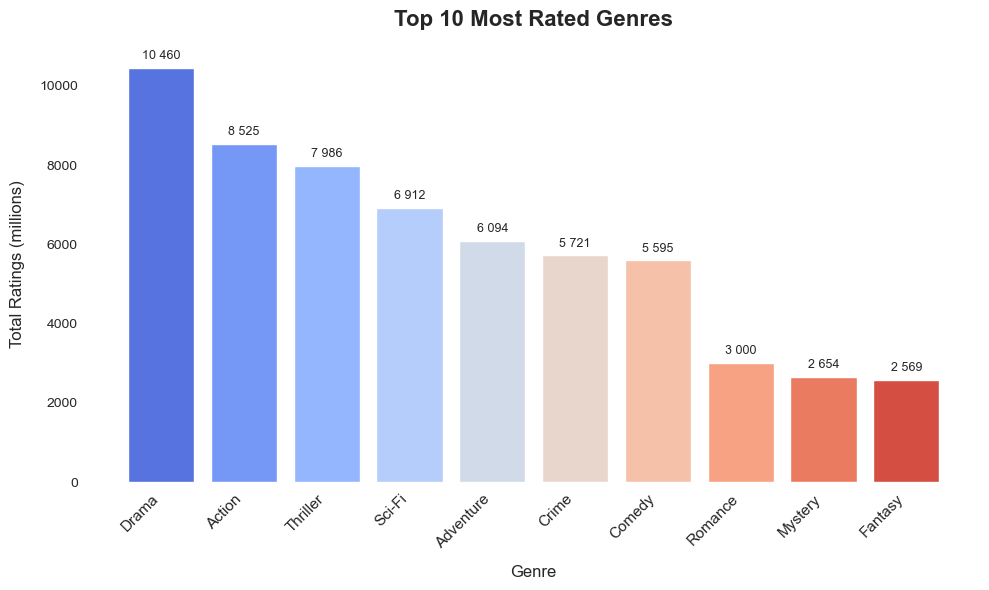

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
plt.figure(figsize=(10, 6))

bars = plt.bar(
    df_genres_pd["genres"],
    df_genres_pd["total_ratings"] / 1e6,
    color=sns.color_palette("coolwarm", len(df_genres_pd)),
    edgecolor="white",
    linewidth=1
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 150,
        f"{int(height):,}".replace(",", " "),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="medium"
    )

plt.title("Top 10 Most Rated Genres", fontsize=16, weight="bold", pad=15)
plt.xlabel("Genre", fontsize=12, labelpad=10)
plt.ylabel("Total Ratings (millions)", fontsize=12, labelpad=10)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




### **Insight**

From the visualization, it becomes evident that **Drama** stands out as the most popular genre, 
accumulating the highest number of ratings overall. **Action** and **Thriller** follow closely, 
reflecting their sustained audience engagement and mainstream appeal.  
Genres such as **Romance**, **Mystery**, and **Fantasy** appear with significantly fewer ratings, 
suggesting a more niche audience or less frequent interaction from users.


## 🎯 Question 2 — What are the highest rated genres?

After understanding which genres receive the largest number of ratings — representing *popularity* — 
we now shift the focus to **quality perception**.  
In this step, we aim to identify which genres achieve the **highest average ratings**, 
revealing users’ most appreciated types of movies.

This analysis highlights genres that, although possibly less mainstream, 
tend to receive consistently higher evaluations from users.


In [96]:
df_genres_avg = (
    df_moviedetails_exploded
    .group_by("genres")
    .agg([
        pl.col("average_rating").mean().alias("avg_rating"),
        pl.len().alias("n_movies")
    ])
    .sort("avg_rating", descending=True)
    .head(10)
)
df_genres_avg_pd = df_genres_avg.to_pandas()
df_genres_avg_pd


,genres,avg_rating,n_movies
0,Documentary,3.339721,9363
1,Film-Noir,3.322674,353
2,IMAX,3.236715,195
3,Musical,3.193193,1059
4,War,3.173634,2325
5,Drama,3.116606,34175
6,Romance,3.090371,10369
7,Animation,3.058072,4617
8,Crime,3.022689,6976
9,Comedy,2.985681,23124


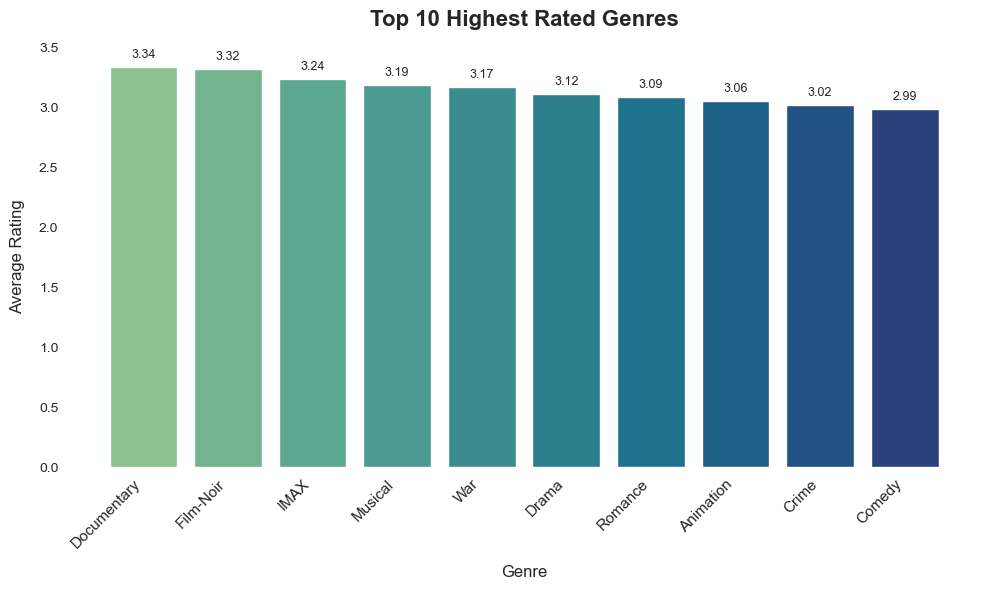

In [99]:
sns.set_style("white")
plt.figure(figsize=(10, 6))

bars = plt.bar(
    df_genres_avg_pd["genres"],
    df_genres_avg_pd["avg_rating"],
    color=sns.color_palette("crest", len(df_genres_avg_pd)),
    edgecolor="white",
    linewidth=1
)


for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="medium"
    )

plt.title("Top 10 Highest Rated Genres", fontsize=16, weight="bold", pad=15)
plt.xlabel("Genre", fontsize=12, labelpad=10)
plt.ylabel("Average Rating", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### **Insight**

The results indicate that genres such as **Documentary**, **Film-Noir**, and **IMAX** receive the highest average ratings, 
suggesting that audiences tend to value films that offer more artistic or immersive experiences.  
These genres, while not necessarily the most popular, often appeal to niche viewers and are appreciated for their 
depth, realism, or technical quality.

On the other hand, genres like **Comedy** and **Crime**, despite being widely watched, tend to have slightly lower 
average ratings. This could be explained by the diversity of audience expectations and the greater variability 
in the quality of productions within these categories.


## 🎬 Question 3 — How do genres relate to popularity and quality?

Having analyzed which genres are *most rated* and *highest rated* separately,  we now combine both perspectives to explore whether **popularity correlates with quality**.

This analysis investigates if genres that attract more audience engagement (measured by total number of ratings) are also those that receive higher average ratings — or if niche genres tend to be better rated despite having fewer viewers.


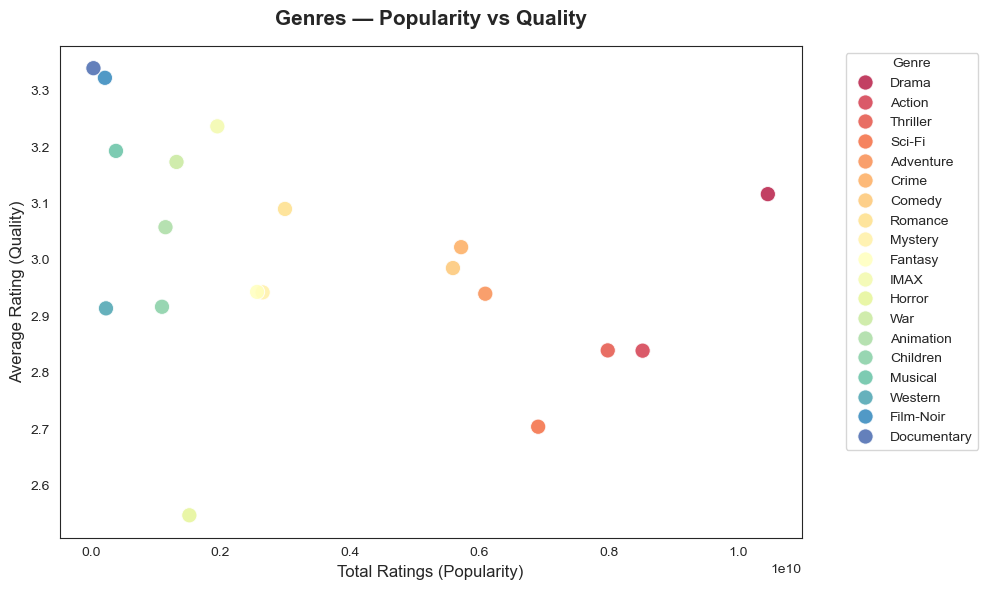

In [100]:

df_scatter = df_moviedetails_exploded.to_pandas()

genre_summary = (
    df_scatter.groupby("genres", as_index=False)
    .agg({
        "average_rating": "mean",
        "rating_count": "sum"
    })
    .sort_values("rating_count", ascending=False)
)

plt.figure(figsize=(10, 6))
sns.set_style("white")

sns.scatterplot(
    data=genre_summary,
    x="rating_count",
    y="average_rating",
    hue="genres",
    s=120,
    palette="Spectral",
    alpha=0.85,
    edgecolor="white",
    linewidth=0.7
)

plt.title("Genres — Popularity vs Quality", fontsize=15, weight="bold", pad=15)
plt.xlabel("Total Ratings (Popularity)", fontsize=12)
plt.ylabel("Average Rating (Quality)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Genre")
plt.grid(False)
plt.tight_layout()
plt.show()


### **Insight**

The visualization clearly shows that the relationship between popularity and quality is weak or even inverse.  
Genres such as **Drama**, **Action**, and **Comedy** attract the largest audiences and therefore accumulate the highest number of ratings — yet their **average ratings hover around 3.0**, suggesting a more mixed audience perception.  

Conversely, genres like **Documentary**, **Film-Noir**, and **IMAX** receive **fewer ratings overall** but stand out with **higher average scores**, indicating that these genres appeal to smaller, more appreciative audiences.  

In short, **popular genres are not necessarily the best rated**, and niche genres tend to deliver higher satisfaction among viewers.


## 🎞️ Question 4 — How have movie ratings evolved over time?

After exploring popularity and genre preferences,  it’s important to examine the **temporal evolution of ratings** —  to understand whether audience behavior and film appreciation have changed over the years.

This analysis aims to uncover **trends in average movie ratings over time**,  helping us identify periods of higher or lower audience satisfaction and potential shifts in rating culture.


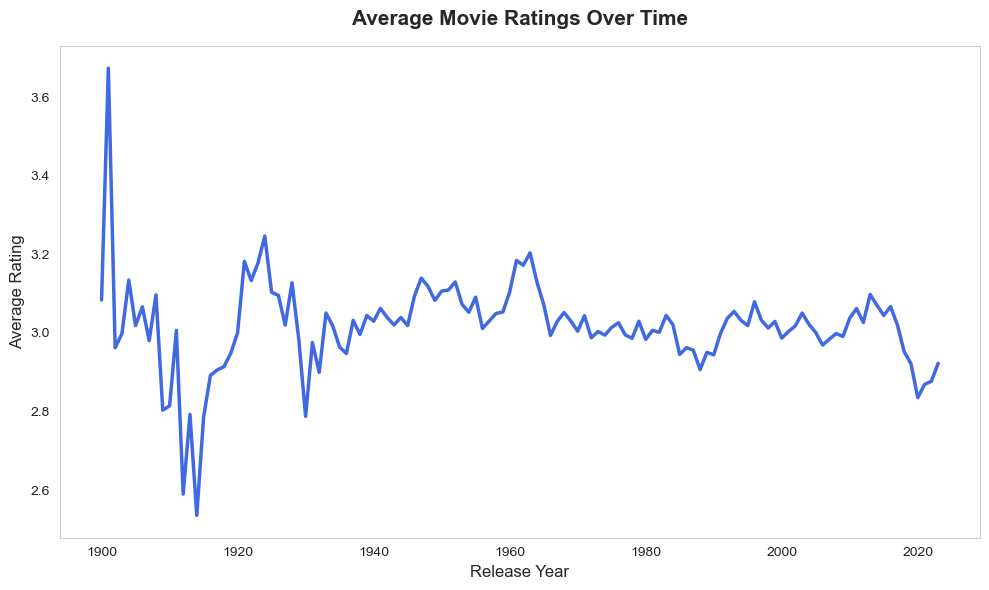

In [101]:
df_time = df_moviedetails.to_pandas()

df_time = df_time[(df_time['year'] >= 1900) & (df_time['year'] <= 2025)]

ratings_over_time = (
    df_time.groupby('year', as_index=False)
    .agg({'average_rating': 'mean', 'rating_count': 'sum'})
)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=ratings_over_time,
    x='year',
    y='average_rating',
    color='royalblue',
    linewidth=2.5
)

plt.title("Average Movie Ratings Over Time", fontsize=15, weight='bold', pad=15)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


### **Insight**

The trend over time shows that average movie ratings have fluctuated across decades,  with early cinema (pre-1930) showing strong variation — likely due to fewer films and a selective rating base.  

From the **1950s to the 2000s**, ratings appear to stabilize around **3.0 to 3.2**, suggesting  a period of consistent audience perception and more balanced evaluation across genres and styles.  

In the **most recent years**, a slight decline is visible, possibly reflecting a **larger and more diverse rating population**, the **rise of streaming platforms**,  
and the **increased volume of movie production**, which tends to dilute extreme ratings.  

Overall, while audience behavior evolves, the long-term average remains stable, indicating a relatively consistent perception of film quality through time.


## 🌍 Question 5 — How have movie genres evolved over decades?

After exploring which genres are most popular and highest rated,  we now turn to a **temporal perspective** — examining how different genres have evolved in terms of their **average ratings and audience engagement** across decades.  

This question allows us to identify **cultural and cinematic trends** — how preferences shifted from classic dramas to action-packed blockbusters or sci-fi adventures, and whether these shifts align with **technological progress or historical events**.  

By analyzing long-term trends, we can gain insight into how cinema reflects society’s evolving interests, values, and global circumstances.


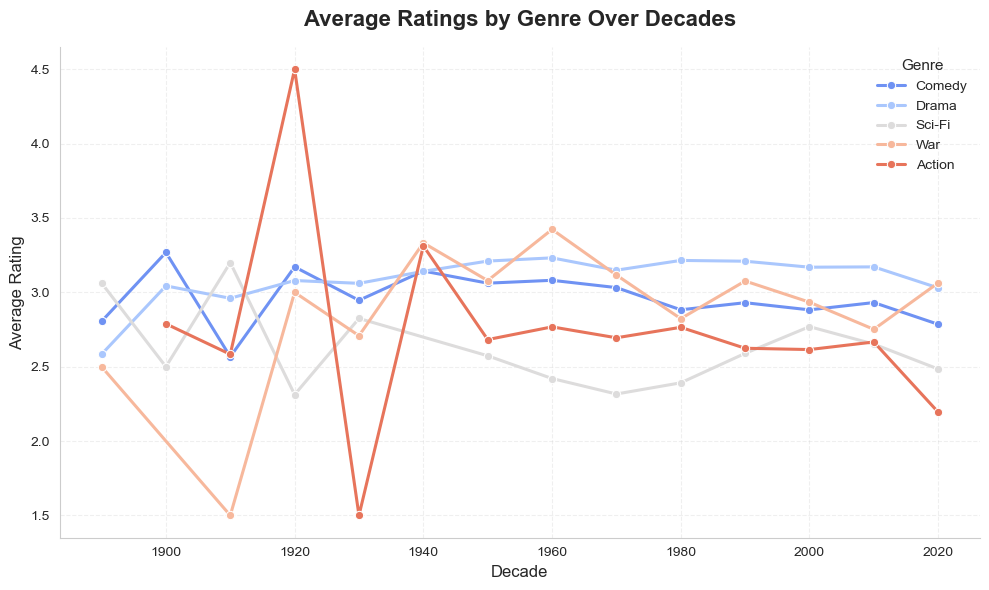

In [104]:

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

palette = sns.color_palette("coolwarm", 5)

sns.lineplot(
    data=df_genre_trends[df_genre_trends["genres"].isin(selected_genres)],
    x="decade", y="average_rating", hue="genres",
    marker="o", linewidth=2.2, palette=palette
)

plt.title("Average Ratings by Genre Over Decades", fontsize=16, weight="bold", pad=15)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Genre", title_fontsize=11, fontsize=10, frameon=False)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

sns.despine()

plt.show()




### **Insight**

The evolution of average ratings across decades reveals interesting long-term patterns.  
Genres such as **Drama** and **Comedy** have remained relatively stable, maintaining consistent audience appreciation over time.  
Meanwhile, **Action** films show a rise in ratings during the late 20th century — reflecting the technological boom in filmmaking and the rise of blockbuster culture after the 1980s.  

On the other hand, **War** movies present sporadic peaks, often coinciding with or following real-world conflicts (e.g., post–World War II and the early 2000s after the 9/11 attacks), suggesting that global events may subtly influence audience interest in certain genres.  

Overall, while tastes and production styles evolve, cinema’s core genres continue to resonate with audiences, each adapting to the social and cultural context of its time.


### 🎯 **Question 6 — Who are the most active reviewers?**

To explore user engagement, we identify the users who have contributed the **highest number of movie ratings**.  
This helps us understand participation dynamics within the platform — whether user activity is evenly distributed or concentrated among a few highly active individuals.  
Such insights reveal how much influence certain users might have over global trends and the perception of movie popularity or quality.



/var/folders/cg/x3kc5__n149gw433jqwwxnwh0000gn/T/ipykernel_1914/192441780.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=df_user_activity, x="userId", y="n_ratings", palette=palette)


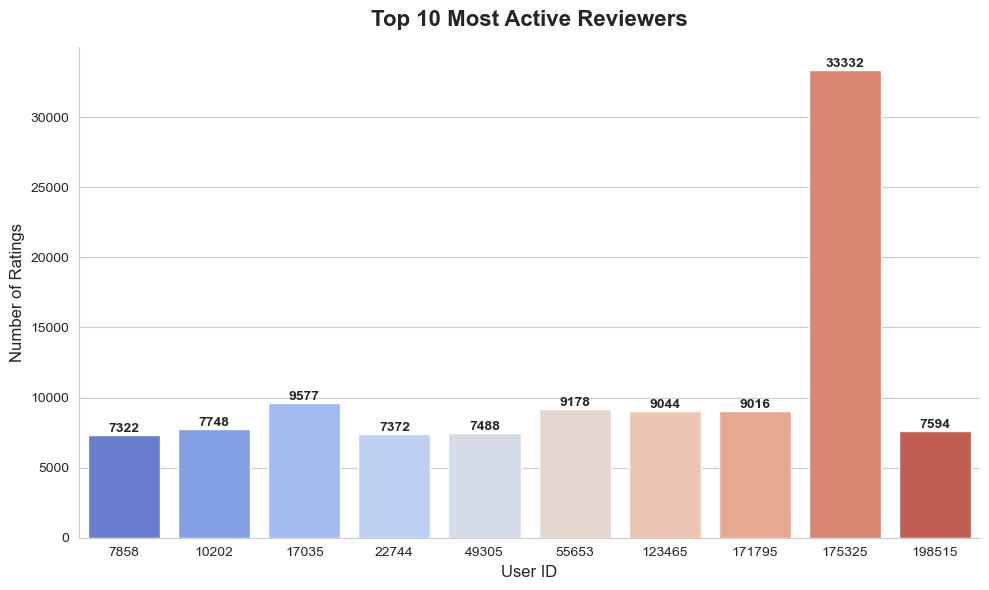

In [111]:

df_ratings = df_ratings.to_pandas() if not isinstance(df_ratings, pd.DataFrame) else df_ratings

df_user_activity = (
    df_ratings
    .groupby("userId", as_index=False)
    .agg(n_ratings=("rating", "count"), avg_rating=("rating", "mean"))
    .sort_values(by="n_ratings", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
palette = sns.color_palette("coolwarm", len(df_user_activity))

bars = sns.barplot(data=df_user_activity, x="userId", y="n_ratings", palette=palette)

for bar in bars.patches:
    bars.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 10,
        f"{int(bar.get_height())}",
        ha='center', va='bottom', fontsize=10, weight='bold'
    )

plt.title("Top 10 Most Active Reviewers", fontsize=16, weight="bold", pad=15)
plt.xlabel("User ID", fontsize=12)
plt.ylabel("Number of Ratings", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()



### 🧠 **Insight — User Engagement Distribution**

The analysis of user activity shows a **highly uneven distribution of participation**.  
While most of the top reviewers contributed between **7,000 and 9,500 ratings**, one user stands out with more than **33,000 reviews** — over three times higher than any other.  

This highlights the presence of **super-reviewers**, whose behavior significantly shapes overall averages and genre visibility.  
Such users often represent **dedicated, long-term contributors**, but they can also introduce **rating bias** if their preferences dominate the dataset.  

Recognizing this imbalance is essential for improving **recommendation fairness**, **community management**, and ensuring that platform insights reflect the opinions of the wider audience rather than a small subset of extremely active users.


### 🎭 **Question 7 — Do the most active users tend to give higher or lower ratings?**

Building on the previous analysis of reviewer activity, we now explore whether **user engagement correlates with rating behavior**.  
Specifically, we examine if users who rate more movies tend to be **more generous or more critical** in their evaluations.  

Understanding this relationship helps assess potential **bias in rating distributions** — for instance, whether a small number of highly active users might systematically **inflate or deflate overall averages**, influencing how movies are perceived across the platform.  
This analysis provides insight into the **consistency, subjectivity, and reliability** of crowd-based movie evaluations.


/var/folders/cg/x3kc5__n149gw433jqwwxnwh0000gn/T/ipykernel_1914/1908742275.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


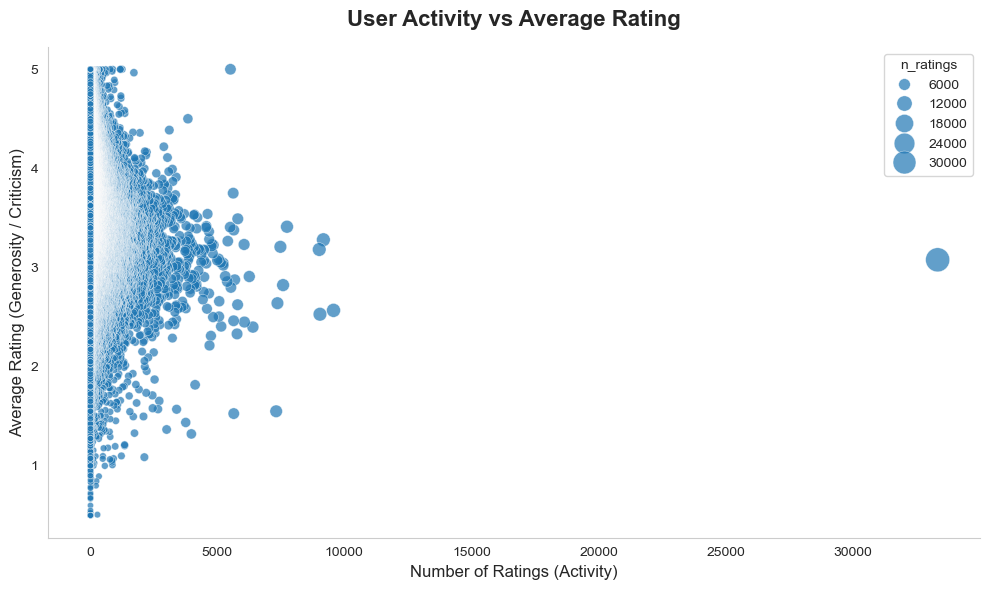

In [112]:
df_user_bias = (
    df_ratings
    .groupby("userId", as_index=False)
    .agg(n_ratings=("rating", "count"), avg_rating=("rating", "mean"))
)

df_user_bias = df_user_bias.sort_values(by="n_ratings", ascending=False)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=df_user_bias,
    x="n_ratings",
    y="avg_rating",
    size="n_ratings",
    sizes=(20, 300),
    alpha=0.7,
    palette="coolwarm"
)

plt.title("User Activity vs Average Rating", fontsize=16, weight="bold", pad=15)
plt.xlabel("Number of Ratings (Activity)", fontsize=12)
plt.ylabel("Average Rating (Generosity / Criticism)", fontsize=12)
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()


### 🧠 **Insight — Relationship Between Activity and Rating Behavior**

The scatter plot reveals a clear **concentration of users with few ratings**, most clustering around an **average score between 2.5 and 4.0**.  
This indicates that the majority of users engage casually, rating only a handful of movies while maintaining similar scoring patterns.  

Interestingly, even the **most active reviewers** — those who have rated thousands of movies — do not deviate significantly from this central trend.  
Their average ratings remain close to the overall mean, suggesting that **high activity does not necessarily imply higher generosity or greater criticism**.  

In other words, **user activity is largely independent of rating bias**.  
While a few outliers exist, the overall stability of averages across activity levels indicates a **balanced and consistent evaluation culture** within the platform’s user base.


### 🎬 **Question 8 — Do longer movies receive higher or lower ratings?**

Does spending more time watching a film make it more rewarding — or more exhausting?  
In this question, we explore the relationship between **movie runtime** and **average rating** to uncover whether longer films are perceived as higher quality, or if audience patience eventually wears thin.  
This analysis can reveal whether there’s an optimal movie length that balances depth and engagement.


In [116]:
!pip install datasets --quiet

In [118]:
!pip install --upgrade --force-reinstall pyarrow --quiet
!pip install --upgrade datasets --quiet


In [122]:
!pip uninstall -y pyarrow datasets


Found existing installation: datasets 4.4.1
Uninstalling datasets-4.4.1:
  Successfully uninstalled datasets-4.4.1


In [123]:
!pip install pyarrow==17.0.0 datasets==3.1.0 --quiet


In [124]:
from datasets import load_dataset

imdb_data = load_dataset("ashraq/imdb-datasets", "title_basics")
imdb_df = imdb_data["train"].to_pandas()
imdb_df.head()


ValueError: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 112 from C header, got 104 from PyObject

## **5. Conclusions**

	•	Identificar que fatores explicam melhor as boas avaliações.
	•	Propor extensão:
	•	Modelo preditivo por utilizador (colaborativo)
	•	Integração com tags para enriquecer o conteúdo


Gráficos:
	•	Scatter n_ratings vs avg_rating (com tendência)
	•	Boxplots de avg_rating por género
	•	Importância das features no modelo
	•	Insights:
	•	Géneros com maiores médias
	•	Géneros mais populares
	•	Relação entre popularidade e qualidade percebida
